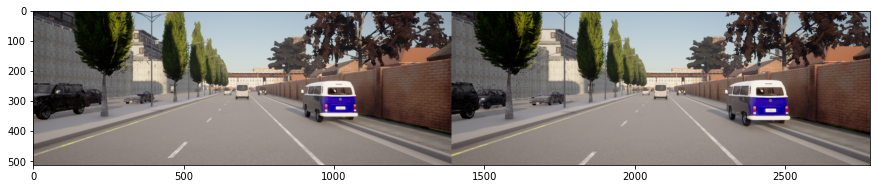

In [13]:
%matplotlib inline

import numpy as np
from numpy.matlib import repmat
import glob
import matplotlib.pyplot as plt
import json
from skimage import io


def read_depth(depth_file):
    depth = io.imread(depth_file)
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    return depth

def plot_pair(img1_path, img2_path):
    plt.figure(figsize=(15,5))
    img0 = plt.imread(img1_path)
    img1 = plt.imread(img2_path)
    plt.imshow(np.hstack((img0, img1)))
    plt.show()

def print_matrix(matrix):
    matrix = np.array(matrix)
    for i in range(matrix.shape[0]):
        print(matrix[i,:])
    print("\n")

data_root = "/storage/remote/atcremers40/motion_seg/datasets/Carla_Ext/Carla_Export_Depth/"
images = sorted(list(glob.glob(os.path.join(data_root, f"images/**/*.png"))))
transformations = sorted(list(glob.glob(os.path.join(data_root, f"transformations/**/*.json"))))
depths = sorted(list(glob.glob(os.path.join(data_root, f"depth/**/*.png"))))

first_image_idx = 80

plot_pair(images[first_image_idx], images[first_image_idx+1])

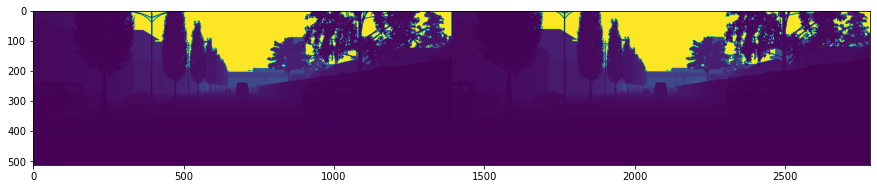

(512, 1392)


In [14]:
depth0 = plt.imread(depths[first_image_idx])
depth1 = plt.imread(depths[first_image_idx+1])
plot_pair(depths[first_image_idx], depths[first_image_idx+1])

print(depth0.shape)

In [15]:
with open(transformations[0], "r") as f:
    trs_list = json.load(f)["transforms"]

trs0 = np.array(trs_list[first_image_idx])
trs1 = np.array(trs_list[first_image_idx+1])

print_matrix(trs0)    # filler matrix
print_matrix(trs1)    # 0_T_1  -> 1to0 but we want 0to1 therefore we want inv(trs1)

[1.00000000e+00 1.57605041e-05 2.51838917e-11 1.42398725e+00]
[-1.57605041e-05  1.00000000e+00  1.06529440e-06  2.01368602e-05]
[-8.39431487e-12 -1.06529440e-06  1.00000000e+00 -2.95444784e-06]
[0. 0. 0. 1.]


[1.00000000e+00 3.33935434e-06 1.77865824e-12 1.42398738e+00]
[-3.33935434e-06  1.00000000e+00 -1.06525797e-06  3.39975140e-05]
[-5.33593206e-12  1.06525797e-06  1.00000000e+00 -2.71598590e-06]
[0. 0. 0. 1.]




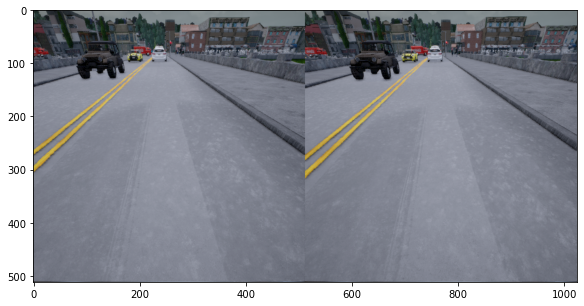

In [8]:
# use carla dataset from week4

data_root = "/storage/group/intellisys/datasets/carla/3d_motion/moving/episode_000"
image_path = os.path.join(data_root, "CameraRGB0")
image_depth = os.path.join(data_root, "CameraDepth0")
transform_path = os.path.join(data_root, "transforms.json")
intrinsics_path = os.path.join(data_root, "camera_intrinsic.json")

with open(intrinsics_path, "r") as f:
    intrinsics = np.array(json.load(f))
K = intrinsics

with open(transform_path, "r") as f:
    transforms = json.load(f)
keys = list(transforms.keys())

first_image_idx = 90
depths = sorted(list(glob.glob(os.path.join(image_depth, f"*.png"))))
depth0 = read_depth(depths[first_image_idx])
depth1 = read_depth(depths[first_image_idx+1])

images = sorted(list(glob.glob(os.path.join(image_path, f"*.png"))))
image0 = plt.imread(images[first_image_idx])
image1 = plt.imread(images[first_image_idx+1])

plot_pair(images[first_image_idx], images[first_image_idx + 1])

# i+1_T_i -> i2i+1
trs0_in_world = transforms[keys[first_image_idx]][0]
# print_matrix(trs0_in_world)
trs1_in_world = transforms[keys[first_image_idx+1]][0]
# print_matrix(trs1_in_world)
trs1 = np.linalg.inv(trs0_in_world) @ trs1_in_world
# print_matrix(trs1)
# print_matrix(np.linalg.inv(trs1))


In [16]:
def get_intrinsics(fov, image_size_x, image_size_y):
    f = image_size_x/(2.0 * np.tan(fov * np.pi /360))
    Cx = image_size_x / 2.0
    Cy = image_size_y / 2.0
    return np.array([[f, 0, Cx], [0, f, Cy], [0, 0, 1]])

def reproject(u, depth, image_size_x, image_size_y, K=None):
    '''
    get [u,v] pixel coordinates and convert to homogeneous
    get instrinsics
    multiply inverse K with the homogeneous points and scale depth
    '''
    # unpacking (christmas presents)
    u_coords, v_coords = u[:,0], u[:,1]

    # get homogeneous coords
    p = np.array([u_coords, v_coords, np.ones_like(u_coords)])

    # get K
    if K is None:
        K = get_intrinsics(72/(2*np.pi), image_size_x, image_size_y)

    # get 3D points
    p3d = np.dot(np.linalg.inv(K), p) * depth.reshape((-1)) * 1000
    return p3d.T

def rotx(angle):
    return np.array([
        [1,0,0,0],
        [0,np.cos((angle*np.pi)/180), -np.sin((angle*np.pi)/180), 0],
        [0,np.sin((angle*np.pi)/180), np.cos((angle*np.pi)/180), 0],
        [0,0,0,1]
    ])

def roty(angle):
    return np.array([
        [np.cos((angle*np.pi)/180),0, np.sin((angle*np.pi)/180),0],
        [0,1,0,0],
        [-np.sin((angle*np.pi)/180),0, np.cos((angle*np.pi)/180),0],
        [0,0,0,1]
    ])

def rotz(angle):
    return np.array([
        [np.cos((angle*np.pi)/180), -np.sin((angle*np.pi)/180),0,0],
        [np.sin((angle*np.pi)/180), np.cos((angle*np.pi)/180),0,0],
        [0,0,1,0],
        [0,0,0,1]
    ])

def build_se3(rotation, translation):
    se3 = np.hstack((rotation, np.array([translation]).T))
    se3 = np.vstack((se3,np.array([0,0,0,1])))
    return se3

def transform_pointcloud(pc, trs):
    # somehow ensure correct direction of trs
    pc = np.hstack([pc, np.zeros((pc.shape[0],1))])
    pc_trs = trs@pc.T
    return pc_trs[:3,:].T

def project(p3d, image_size_x, image_size_y):
    '''
    gets intrinsics, projects points into the image plane
    and normalised the pixels
    '''   
    K = get_intrinsics(72/(2*np.pi), image_size_x, image_size_y)
    unnormalised_pixel_coords = np.dot(K, p3d.T).T
    pixel_coords = unnormalised_pixel_coords/(unnormalised_pixel_coords[:,2]).reshape((-1,1))
    return pixel_coords[:,:2]

def get_flow(depth0, image_size_x, image_size_y, trs, K=None):
    # 2d pixel coordinates
    pixel_length = image_size_x * image_size_y
    u_coords = repmat(np.r_[image_size_x-1:-1:-1],
                        image_size_y, 1).reshape(pixel_length)
    v_coords = repmat(np.c_[image_size_y-1:-1:-1],
                        1, image_size_x).reshape(pixel_length)

    u_coords = np.flip(u_coords)
    v_coords = np.flip(v_coords)
    u = np.array([u_coords, v_coords]).T

    pc0 = reproject(u, depth0, image_size_x, image_size_y, K)

    # find transformation
    trs = np.linalg.inv(trs)

    # trs = np.linalg.inv(roty(90))@trs
    # print(trs[:3,3])

    pc0_trs = transform_pointcloud(pc0, trs)
    u_dash = project(pc0_trs, image_size_x, image_size_y)

    flow = u_dash - u
    print(flow)
    flow = flow.reshape(image_size_y, image_size_x, 2)

    return flow
   
# trs = build_se3(np.eye(3), np.array([500,1,0]))
opt_flow = get_flow(depth0, 1392, 512, trs1)
# opt_flow = get_flow(depth0, 512, 512, trs1, K)

[[ 0.0008822   0.00507534]
 [ 0.00088216  0.00507868]
 [ 0.00088212  0.00508202]
 ...
 [-0.00082444  0.00971362]
 [-0.0008244   0.00971696]
 [-0.00082436  0.0097203 ]]


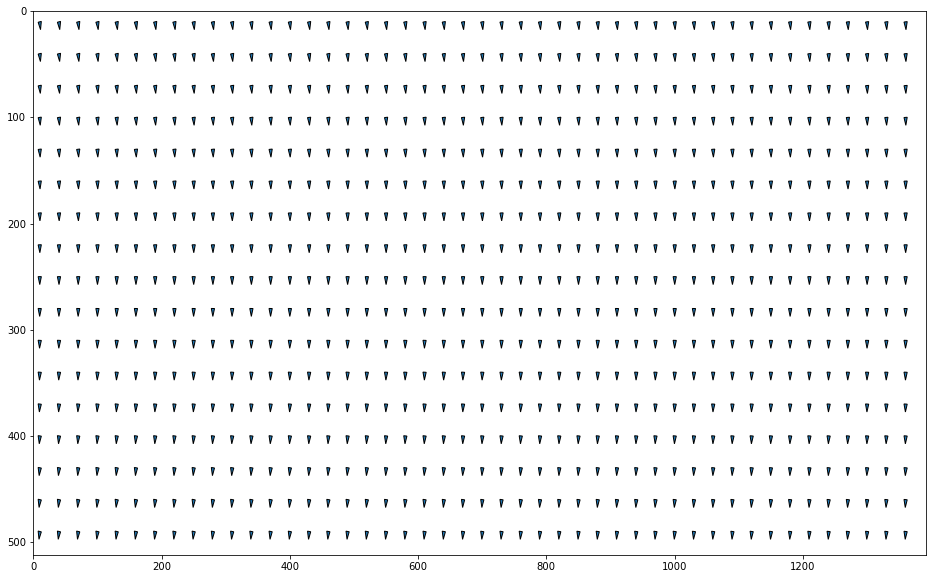

In [17]:
#Visualization of flow vectors 
fig = plt.figure(figsize = (16,10))
# plt.xlim(0,512)
plt.xlim(0,1392)
plt.ylim(0,512)
plt.gca().invert_yaxis()

disc_step = 30
offset = 10

for i in range(offset, opt_flow.shape[0]-offset, disc_step):
    for j in range(offset,opt_flow.shape[1]-offset, disc_step):
        plt.arrow(j,i,opt_flow[i,j,0], opt_flow[i,j,1], head_width=5)
fig.show()

In [ ]:
# examples/Python/Basic/icp_registration.py

import open3d as o3d
import numpy as np
import copy


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])


if __name__ == "__main__":
    source = o3d.io.read_point_cloud("../../TestData/ICP/cloud_bin_0.pcd")
    target = o3d.io.read_point_cloud("../../TestData/ICP/cloud_bin_1.pcd")
    threshold = 0.02
    trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                             [-0.139, 0.967, -0.215, 0.7],
                             [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
    draw_registration_result(source, target, trans_init)
    print("Initial alignment")
    evaluation = o3d.registration.evaluate_registration(source, target,
                                                        threshold, trans_init)
    print(evaluation)

    print("Apply point-to-point ICP")
    reg_p2p = o3d.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPoint())
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)
    print("")
    draw_registration_result(source, target, reg_p2p.transformation)

    print("Apply point-to-plane ICP")
    reg_p2l = o3d.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPlane())
    print(reg_p2l)
    print("Transformation is:")
    print(reg_p2l.transformation)
    print("")
    draw_registration_result(source, target, reg_p2l.transformation)